# Переобучение

Википедия: <br>"<b>Переобучение</b> (переподгонка, пере- в значении «слишком», англ. overfitting) в машинном обучении и статистике — явление, когда построенная модель хорошо объясняет примеры из обучающей выборки, но относительно плохо работает на примерах, не участвовавших в обучении (на примерах из тестовой выборки)."

<img src="imgs/overfitting.png" align=left>
<img src="imgs/overfitting2.png">

In [7]:
%matplotlib inline
%pylab inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Решающее дерево в задаче регрессии

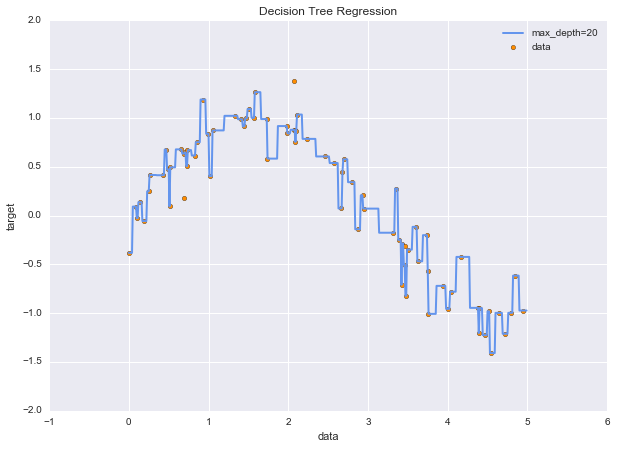

In [22]:
from sklearn.tree import DecisionTreeRegressor

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
# y = np.piecewise(X.flatten(), [X.flatten() < 3, X.flatten() >= 3], [-1, 1]).ravel()
y[::2] += 1 * (0.5 - rng.rand(40))

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]


def fit_predict_plot(max_depth=1):
    clf = DecisionTreeRegressor(max_depth=max_depth)
    clf.fit(X, y)
    plt.figure(figsize=(10, 7))
    plt.scatter(X, y, c="darkorange", label="data")
    y_pred = clf.predict(X_test)
    plt.plot(X_test, y_pred, color="cornflowerblue", label='max_depth=' + str(max_depth), linewidth=2)
    
#     clf2 = DecisionTreeRegressor(max_depth=max_depth, criterion='mae')
#     clf2.fit(X, y)
#     y_pred2 = clf2.predict(X_test)
#     plt.plot(X_test, y_pred2, color="green", label='max_depth=' + str(max_depth), linewidth=2)
    
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Decision Tree Regression")
    plt.legend()

from ipywidgets import interact, fixed
_ = interact(fit_predict_plot, max_depth=(1, 20)) 

In [177]:
a = [1,2,3,4,5,6]
b = [1,2,3,4,5,6]
rng.shuffle(a)
rng.shuffle(b)
print a, b

[5, 2, 4, 3, 1, 6] [1, 6, 2, 4, 5, 3]


In [111]:

X.shape

(100, 2)

# 1-й хак: Dimention reduction
На каждом сплите ноды дерева, мы выбираем лучший сплит не из всех координат, а из части

<b>N/3</b> - для регрессии<br>
<b>sqrt(N)</b> - для классификации

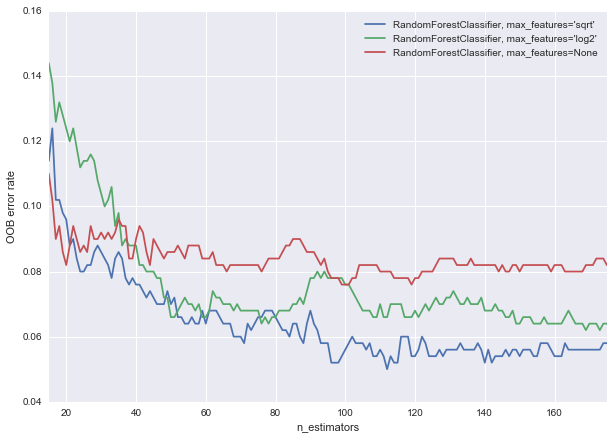

In [9]:
figure(figsize=(10,7))

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123


# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

# 2-й хак: Bootstrap aggregating aka Bagging
<img src='imgs/the-bootstrap-and-beyond-using-jsl-for-resampling-38-638.jpg' width=600>

Размер новой выборки такой же как размер старой. Количество уникальных элементов в новой выборке - (1 - 1/e) (≈63.2%) 

Много формул: https://youtu.be/5Lu1eTiX7qM

<img src='imgs/precision-and-bias.png'>

# Случайный лес

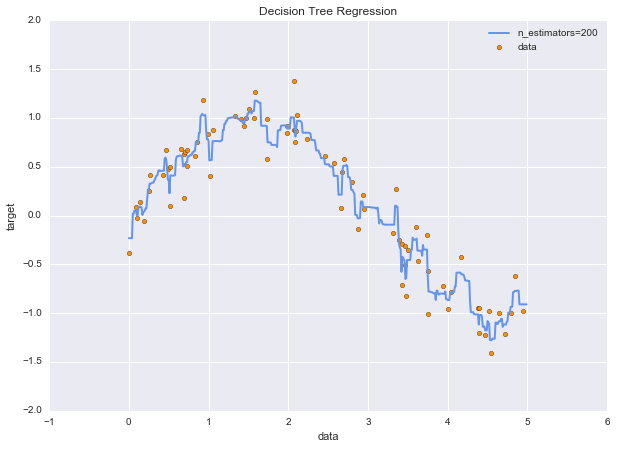

In [23]:
from sklearn.ensemble import RandomForestRegressor
def fit_predict_plot_rf(n_estimators):
    clf = RandomForestRegressor(n_estimators=n_estimators)
    clf.fit(X, y)

    # Predict
    plt.figure(figsize=(10, 7))
    plt.scatter(X, y, c="darkorange", label="data")
    y_pred = clf.predict(X_test)
    plt.plot(X_test, y_pred, color="cornflowerblue", 
             label='n_estimators=' + str(n_estimators), linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Decision Tree Regression")
    plt.legend()

from ipywidgets import interact, fixed
_ = interact(fit_predict_plot_rf, n_estimators=(1, 200))


# Решающее дерево в классификации

In [24]:
from IPython.display import HTML

HTML(data="""<iframe width="854" height="480" 
    src="https://www.youtube.com/embed/p17C9q2M00Q" 
            frameborder="0" allowfullscreen></iframe>""")

# Причем здесь ирис?
<img src='imgs/iris_petal_sepal.png'>

In [26]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier


# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02


# Load data
iris = load_iris()
pair= [0,1]

# We only take the two corresponding features
X = iris.data[:, pair]
y = iris.target
    
def plot_one(max_depth):

    # Train
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42).fit(X, y)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)
    plt.axis("tight")

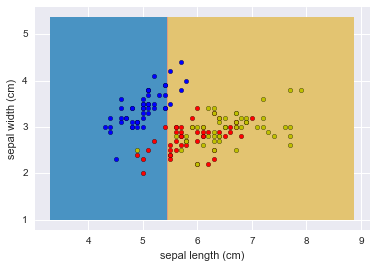

In [27]:
from ipywidgets import interact
_ = interact(plot_one, max_depth=(1, 20)) 

# Визуализация решающего правила

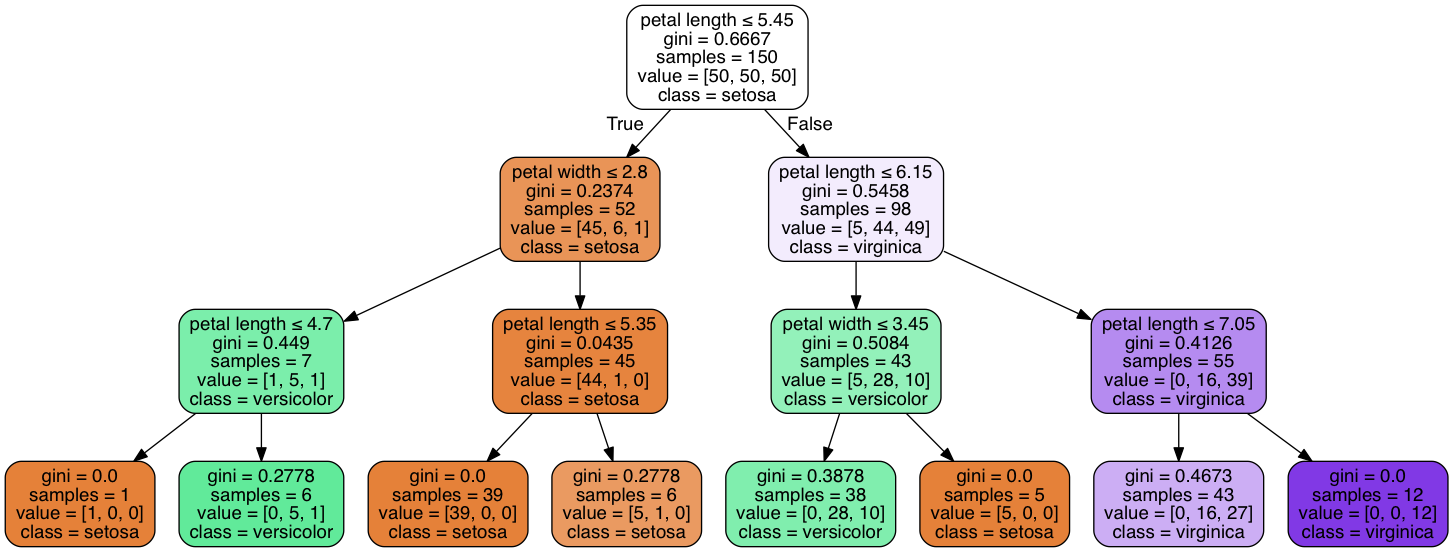

In [29]:
import pydotplus 
from IPython.display import Image
from sklearn import tree

pair = [0, 1]
X = iris.data[:, pair]
y = iris.target

clf = DecisionTreeClassifier(random_state=42, max_depth=3).fit(X, y)  # сказать про min_samples_split

dot_data = tree.export_graphviz(clf, out_file=None, 
                                 feature_names=['petal length', 'petal width'],  
                                 class_names=iris.target_names,  
                                 filled=True, rounded=True,
                                 special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

<img src='imgs/dt_crit0.jpg'>
<img src='imgs/dt_crit1.jpg'>
<img src='imgs/dt_crit2.jpg'>
<img src='imgs/dt_crit3.jpg'>

## больше формул: __articles/decision_trees.pdf

# Ничего лишнего:

In [30]:
X = iris.data
y = iris.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


#######
DT = DecisionTreeClassifier(random_state=42)
DT.fit(X_train, y_train)
print DT.score(X_test, y_test)

#######
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=42, n_estimators=100)
RF.fit(X_train, y_train)
print RF.score(X_test, y_test)

#######
RF = RandomForestClassifier(random_state=42, n_estimators=100, 
                            oob_score=True)
RF.fit(X, y)
print RF.oob_score_

0.911111111111
0.888888888889
0.953333333333


# Визуализация случайного леса

('RF with features ', [0, 1], 'has a score of', 0.92666666666666664)


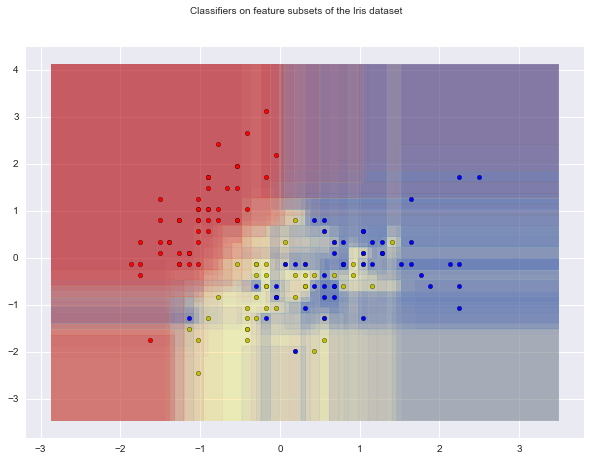

In [31]:
from sklearn.ensemble import RandomForestClassifier

figure(figsize=(10,7))

n_estimators = 30
plot_colors = 'ryb'
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

clf = RandomForestClassifier(n_estimators=n_estimators)
# We only take the two corresponding features
X = iris.data[:, pair]
y = iris.target

# Shuffle
idx = np.arange(X.shape[0])
np.random.seed(RANDOM_SEED)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# Standardize
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

# Train
clf.fit(X, y)

scores = clf.score(X, y)
print( 'RF with features ', pair, "has a score of", scores )

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))


estimator_alpha = 1.0 / len(clf.estimators_)
for tree in clf.estimators_:
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

for i, color in zip(xrange(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i], cmap=cmap)


plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")

plt.show()

Еще примеры:
<a href="http://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png" alt="Нажми меня!"> <img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png"></a>

<img src="https://imgs.xkcd.com/comics/in_the_trees.jpg">